IMPORTING REQUIRED LIBRARIES

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

LOADING DATASET

In [4]:
file_path = '/content/drive/MyDrive/Colab Notebooks/SNT_dataset.csv'
df = pd.read_csv(file_path)


VISUALIZING CLASS DISTRIBUTION OF DATA

<ipython-input-5-b997d77631fc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette="coolwarm")


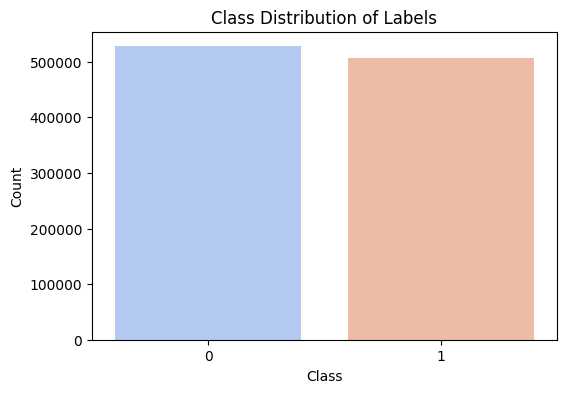

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df['label'], palette="coolwarm")
plt.title("Class Distribution of Labels")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

PREPROCESSING DATA


In [6]:
# Convert numerical columns (fix European-style decimal issues)
for col in df.columns:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(str)
    try:
        df[col] = pd.to_numeric(df[col])
    except ValueError:
        pass  # Ignore non-numeric columns

In [7]:
# Drop unnecessary columns
columns_to_drop = ['timestamp', 'flow_id', 'ip_src', 'ip_dst', 'flow_duration', 'packet_count_per_nsecond', 'byte_count_per_nsecond']
df_cleaned = df.drop(columns=[col for col in columns_to_drop if col in df.columns])



In [9]:
# Encode categorical variables
label_encoder = LabelEncoder()
df_cleaned['label'] = label_encoder.fit_transform(df_cleaned['label'])


In [10]:
# Define features and target
X = df_cleaned.drop(columns=['label']).values
y = df_cleaned['label'].values


In [11]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


TRAIN-TEST SPLIT WITH STRATIFICATION

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)


In [13]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

SPLIT DATA AMONG MULTIPLE CLIENTS  (simulating federated learning)

In [14]:
def split_federated_data(X, y, num_clients=5):
    split_size = len(X) // num_clients
    client_datasets = []
    for i in range(num_clients):
        start = i * split_size
        end = (i + 1) * split_size if i != num_clients - 1 else len(X)
        dataset = TensorDataset(X[start:end], y[start:end])
        client_datasets.append(DataLoader(dataset, batch_size=64, shuffle=True))
    return client_datasets


In [15]:
# Create federated client datasets
client_loaders = split_federated_data(X_train_tensor, y_train_tensor, num_clients=5)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)


DEFINING THE NEURAL NETWORK MODEL




In [16]:

class FedNN(nn.Module):
    def __init__(self, input_size):
        super(FedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.dropout1 = nn.Dropout(0.6)
        self.fc2 = nn.Linear(16, 8)
        self.dropout2 = nn.Dropout(0.6)
        self.fc3 = nn.Linear(8, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

INITIALISING GLOBAL MODEL

In [17]:
global_model = FedNN(input_size=X_train.shape[1])


IMPLEMENT FEDERATED AVERAGING ALGORITHM

In [18]:
def federated_averaging(global_model, client_models):
    global_state_dict = global_model.state_dict()
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack([client_models[i].state_dict()[key] for i in range(len(client_models))], dim=0).mean(dim=0)
    global_model.load_state_dict(global_state_dict)

TRAINING THE MODEL ACROSS MULTIPLE CLIENTS

In [19]:
def train_federated(global_model, client_loaders, epochs=10):
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        client_models = []
        for client_loader in client_loaders:
            model = FedNN(input_size=X_train.shape[1])
            model.load_state_dict(global_model.state_dict())
            optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=5e-3)
            model.train()
            for X_batch, y_batch in client_loader:
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
            client_models.append(model)
        federated_averaging(global_model, client_models)
        print(f"Epoch {epoch+1}/{epochs} completed.")

In [20]:
train_federated(global_model, client_loaders, epochs=15)

Epoch 1/15 completed.
Epoch 2/15 completed.
Epoch 3/15 completed.
Epoch 4/15 completed.
Epoch 5/15 completed.
Epoch 6/15 completed.
Epoch 7/15 completed.
Epoch 8/15 completed.
Epoch 9/15 completed.
Epoch 10/15 completed.
Epoch 11/15 completed.
Epoch 12/15 completed.
Epoch 13/15 completed.
Epoch 14/15 completed.
Epoch 15/15 completed.


EVALUATE PERFORMANCE AND PLOT ACCURACY

In [21]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.numpy())
            y_pred.extend(predicted.numpy())
            y_probs.extend(probs.numpy())
    acc = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred))
    return y_true, y_pred, y_probs

In [22]:
y_true, y_pred, y_probs = evaluate_model(global_model, test_loader)

Test Accuracy: 0.9904
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    158273
           1       0.99      0.99      0.99    152128

    accuracy                           0.99    310401
   macro avg       0.99      0.99      0.99    310401
weighted avg       0.99      0.99      0.99    310401



CONFUSION MATRIX

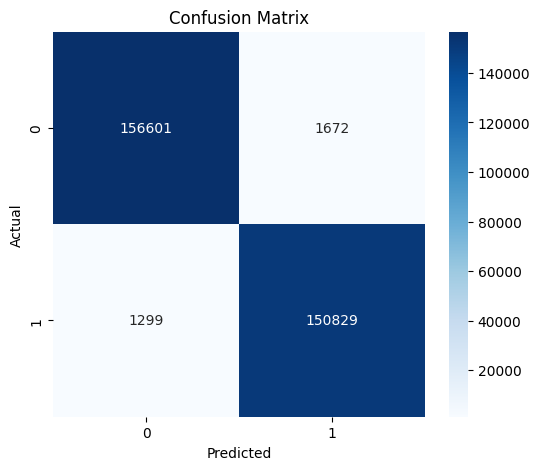

In [23]:
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


ROC CURVE

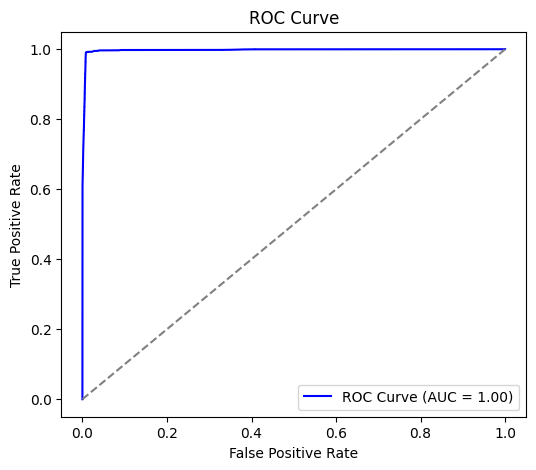

In [24]:
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


DISTRIBUTION OF PREDICTED PROBABILITIES

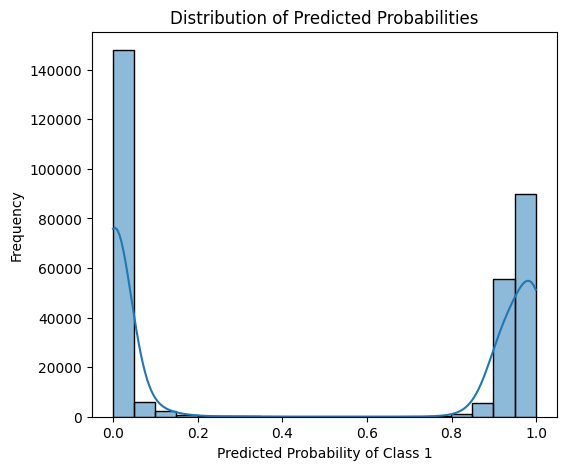

In [25]:
plt.figure(figsize=(6,5))
sns.histplot(y_probs, bins=20, kde=True)
plt.xlabel("Predicted Probability of Class 1")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.show()

MODEL ACCURACY PER CLIENT

Client 1 Accuracy: 0.9904
Client 2 Accuracy: 0.9903
Client 3 Accuracy: 0.9903
Client 4 Accuracy: 0.9899
Client 5 Accuracy: 0.9899


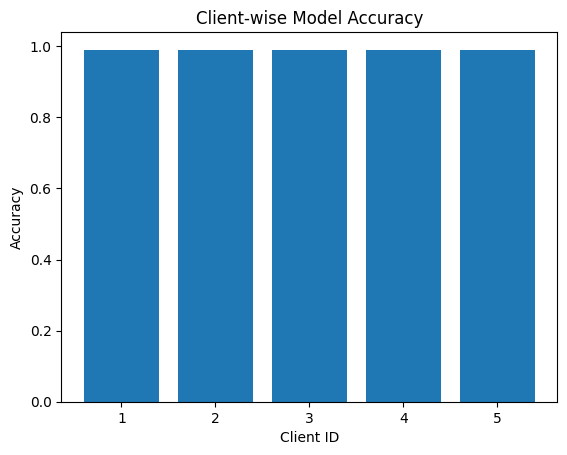

In [27]:
client_accuracies = []

def evaluate_clients(global_model, client_loaders):
    global_model.eval()
    for i, client_loader in enumerate(client_loaders):
        correct, total = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in client_loader:
                outputs = global_model(X_batch)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)
        acc = correct / total
        client_accuracies.append(acc)
        print(f"Client {i+1} Accuracy: {acc:.4f}")

evaluate_clients(global_model, client_loaders)

plt.bar(range(1, len(client_accuracies)+1), client_accuracies)
plt.xlabel("Client ID")
plt.ylabel("Accuracy")
plt.title("Client-wise Model Accuracy")
plt.show()
